# TED Predictions
Nathan Walker - March, 2018
Springbaord Capstone 1

## Table of Contents
1. [Introduction](#1. Introduction)  
2. [Data Cleaning](#2 Data Cleaning)  
    [--Metadata: Library and Data Import](#2 Metadata Import)  
    [--Metadata: Data Cleanup](#2 Metadata Cleanup)  
    [--Transcripts: Library and Data Import](#2 Tran Import)  
    [--Transcripts: Data Cleanup](#2 Tran Cleanup)  
3. [Exploratory Data Analysis](#3 EDA)
4. [Modeling](#4 Modeling)  
5. [Results](#5 Results)  

---


## <a class="anchor" id='1. Introduction'>1. Introduction</a>

TED is a nonprofit that holds multiple conferences about Technology, Entertainment, and Design every year.<sup>[1](https://www.ted.com/about/our-organization)</sup> The process of deciding who speaks at a TED event is rather complicated<sup>[2](http://speaker-nominations.ted.com/)-[3](https://www.ted.com/about/conferences/speaking-at-ted)</sup> and while many talks are engaging and inspiring, some are not well-received.

All recorded talks are available on TED’s YouTube pages, but only the most promising of the bunch are uploaded to the official TED website. Videos on this official site can be rated by users through their choice of up to three predefined category tags, which can be divided into two categories: positive (beautiful, courageous, fascinating, funny, informative, ingenious, inspiring, jaw-dropping, persuasive) and negative (confusing, long-winded, obnoxious, OK, unconvincing). Users are given a search option to view videos that are highly rated in the positive categories (i.e., “Show me videos that are: beautiful” gives a list of the talks that rate high in “beautiful”). 

Because quality content drives TED’s official site’s success, being able to predict the success or failure of a TED talk would be quite valuable. TED employs some unknown system to decide which videos should go on their official site, but even among these hand-selected videos, not all receive overwhelmingly positive reviews. This hand-selection process naturally creates some bias against would-be failures, so unsuccessful videos will be under-represented in the data.  

__The aim of this project is to create a regression model that can predict how successful a new video will be, based on some metadata and its transcript.__

I am defining a video’s success here as a function of the percentage of positive user ratings it receives. That is, a video with 800 ratings in the _positive_ categories and 200 ratings in the _negative_ categories would have a a positive percent of $\frac{800}{800+200} = 0.80$ or 80%. Because modeling on a percent with a bound has certain restraints, a function of this data with desirable qualities is $log(\frac{p}{1-p})$, where $p$ is the percent of positive user ratings.

Metadata included in this assessment is discussed in the [Data Cleaning](#2 Metadata Cleanup) and [Modeling](#3 Modeling) sections, but possible factors include video duration, the kind of TED event at which the talk was presented, the number of main speakers involved in the talk, and anything that can be gleaned from the transcripts themselves (e.g., number of "applause" or "laugher" demarcations).

The transcripts themselves will be used by creating a 128-dimension GloVe<sup>[4](https://nlp.stanford.edu/pubs/glove.pdf)</sup> representation of each document. For each word, these representations are created by training a 300-node, single-layer neural network on overall co-occurence counts for a pair of words. The document representation is the sum of all words in a given document. Because these 128 dimensions are unordered and have no intrisic meaning, the model selection process can pick and choose the most informative ones and leave the others out. This process will be explored more fully in the [Modeling](#3 Modeling) section. GloVe representations will be parsed using spaCy's pre-trained web model, which was trained on common crawl data with 685k keys and 685k distinct vectors.<sup>[5](https://spacy.io/models/en#en_core_web_lg)</sup> The hope here is that there is some pattern in these vectors that can help predict a video's score.

## <a class='anchor' id='2 Data Cleaning'>2. Data Cleaning</a>

A user on Kaggle scraped TED’s online video repository<sup>[6](https://www.ted.com/talks)</sup> on September 21, 2017 and uploaded the dataset to Kaggle.<sup>[7](https://www.kaggle.com/rounakbanik/ted-talks)</sup> There are 2550 videos’ metadata and transcripts in the dataset, in two files. The metadata dataset includes the URL, information on the speaker, the video, community comment counts, and user ratings in different categories (as explained above). The transcript dataset includes the full transcript of each talk, as well as a URL for reference.

To prepare the data for modeling, some preprocessing must take place first.

## <a class='anchor' id='2 Metadata Import'>Metadata: Library and Data Import</a>

The data is in CSV format, so it can be loaded in and explored using the pandas package.

In [1]:
# 1. Library and Data Import

# import libraries
import pandas as pd              # CSV loading, dataframes
import numpy as np               # Math functions
import matplotlib.pyplot as plt  # Plots
import seaborn as sns            # Pretty Plots
import json                      # Convert ratings column
import re                        # Regex

# import data
df_stats = pd.read_csv('ted_main.csv')

# data preview
print(df_stats.info())
df_stats.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null int64
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null int64
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null object
views                 2550 non-null int64
dtypes: int64(7), object(10)
memory usage: 338.8+ KB
None


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292


The ouptut above shows that there are 2550 videos with 17 columns of information each. There are no missing rows in any of the important columns and no important columns with datatypes that must be changed. Let's take a look at the first video as an example and walk through the different columns to see what and how "important" they are:

__comments__: 4553  
This is a count of the number of comments a video has online. Because new videos will necessarily have 0 comments, this column is not useful.  

__description__: "Sir Ken Robinson makes an entertaining and pro..."  
This is just a blurb describing the video. Because this information mirrors the transcript, it will be discarded.  

__duration__: 1164  
This is the number of seconds the video lasts. $\frac{1164}{60} = 19.4$ or 19 minutes and 24 seconds.

__event__: TED2006  
This is the name of the event where the talk took place. In this case, it's the main TED event in 2006. Because there are quite a few different events, as we will see later, this column will need to be reduced.

__film_date__: 1140825600  
This is the date of the talk, but given in Unix timestamp formatting. Because the film date should not affect a user's response to it, this column will be discarded.

__languages__: 60  
This is the number of languages a video has been translated into on TED's website. Because new videos will necessarily have low translation counts, this column will be discarded.

__main_speaker__: Ken Robinson  
This is, as expected, the name of the main speaker. Because most of the speakers have only one video to their name, this column would be too sparse to be useful in the analysis and will be removed.

__name__: "Ken Robinson: Do schools kill creativity?"  
This is the name of the talk as it appears on the TED website. Because this information should be reflected in the transcript, it can be discarded, but will be kept to make looking through the data easier.

__num_speaker__: 1  
This is the number of main speakers in the video. In some cases, there are as many as 5.

__published_date__: 1151367060  
This is the date the video was posted on TED's website (again in Unix format). Because the new videos we are interested in would have a future published date, this column will be discarded.

__ratings__: [{'id': 7, 'name': 'Funny', 'count': 19645}, {'id':...}, ...]  
This is the main column of interest and consists of a list of dictionaries of user ratings. Each rating is given an ID number, a name, and a count. For our purposes, we will need to create two sums from this column, totaling the counts of the "positive" and "negative" ratings.

__related_talks__: [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...}, ...]  
This is just information about what talks TED's algorithms think are most closely related to the current video. It's not intrinsic to the video itself, so it will be discarded.

__speaker_occupation__: Author/educator  
This is the occupation of the main speaker. Because the occupations vary about as wildly as the speaker names, this column will be discarded.

__tags__: ['children', 'creativity', 'culture', 'dance',...	]  
This is a list of words that describe the video and it is not clear how this list was created. Because of this (and because the list is unwieldy and disparate) this column will only be discarded.

__title__: Do schools kill creativity?  
This is just the __name__ column without the speaker name included and will be discarded.

__url__: https://www.ted.com/...  
This is the actual URL for the video. It will be used as a unique identifier for the video (for merging datasets) and will be used to check for transcripts for videos where they are missing.

__views__: 47227110  
This is the number of views the video had when the data was scraped. Because new videos will necessarily have 0 views, this column will be discarded.

---

## <a class='anchor' id='2 Metadata Cleanup'>Metadata: Data Cleanup</a>

There are a few things to be fixed here, but the data looks fairly clean already. The biggest thing to do here is get rid of the many unneeded columns. Our tasks in this section are:

A. Identify and discard duplicate rows (if any).  
B. Remove unneeded columns: __related_talks__, __speaker_occupation__, __comments__, __film_date__, __published_date__, __languages__, __main_speaker__, __speaker_occupation__, __title__, __description__, __tags__, and __views__.  
C. Group __event__ categories, as there are too many options to be useful here.  
D. Create "percent positive ratings" based on the __ratings__ column.

In [2]:
# A. Identify and discard duplicates.

# identify duplicates based on name
dup_list = df_stats.duplicated(subset='name')

# print index of duplicates (if any)
print("Index of duplicates:", list(dup_list[dup_list == True].index))
print("Number of duplicates:", len(dup_list[dup_list == True]))

Index of duplicates: []
Number of duplicates: 0


In [3]:
# B. Remove columns
to_remove = ['related_talks', 'speaker_occupation', 'comments', 'film_date', 'published_date', 'languages', 'main_speaker', 'speaker_occupation', 'title', 'views', 'description', 'tags']
df_stats.drop(columns=to_remove, inplace=True)

In [4]:
# C. Regroup event column

# C1. Find all events
df_stats.event.value_counts()[:25]

TED2014           84
TED2009           83
TED2016           77
TED2013           77
TED2015           75
TEDGlobal 2012    70
TED2011           70
TEDGlobal 2011    68
TED2007           68
TED2010           68
TED2017           67
TEDGlobal 2013    66
TED2012           65
TEDGlobal 2009    65
TED2008           57
TEDGlobal 2010    55
TEDGlobal 2014    51
TED2006           45
TED2005           37
TEDIndia 2009     35
TEDWomen 2010     34
TED2003           34
TEDSummit         34
TED2004           31
TEDWomen 2015     28
Name: event, dtype: int64

There are __355__ different events to begin with (only 25 are shown above), but there are quite a few patterns.  

After searching through the un-shortened version of the above list, a few things become clear:

1. There are non-TED events listed here. Because this study is interested in TED talks, these non-TED talks should be excluded. According to TED's website,<sup>[8](https://www.ted.com/about/conferences/past-teds)</sup> all TED events have "TED" in the name, except the "Mission Blue" series. It should also be noted that TED-Ed videos are actually animated video shorts created for online consumption only<sup>[9](https://www.ted.com/about/programs-initiatives)</sup> and should also be excluded.
2. A good list of categories looks like: 
<ul>
    <li>__TED Yearly__: This is the main event, located somewhere in North America every year.
    <li>__TED Global__: The focus and location for this event are international.
    <li>__TEDx__: These independently-organized events are not "TED," strictly speaking, but share the name and vision of the organization.
    <li>__TED@__: Every year, TED partners with a set of businesses and puts on an event, such as TED@UPS or TED@Intel, with speakers from those companies.
    <li>__TED Women__: These events focus on women's abilities to be and create change in the world.
    <li>__TED Salon__: Instead of a full-on TED event, these events last just an evening.
    <li>__TEDMED__: A focus on health and healthcare from all alngles make these yearly events unique.
    <li>__Other__: There have been plenty of one-off events all over the world with many different focuses. This is the catch-all category for any event or type of event with less than 50 videos in the TED archives.
</ul>

In [5]:
# C2. Categorize

other_list = list()
def event_categorizer(event):
    """
    Returns event type based on event text.
    """
    import re
    
    if re.search('TED[0-9]{4}', event):
        return 'TED Yearly'
    elif re.search('TEDGl', event):
        return 'TED Global'
    elif re.search('TEDx', event):
        return 'TEDx'
    elif re.search('TED@|TEDIndia|TEDNYC', event):
        return 'TED@'
    elif re.search('Salon', event):
        return 'TED Salon'
    elif re.search('Women', event):
        return 'TED Women'
    elif re.search('TEDMED', event):
        return 'TEDMED'
    elif re.search('TED-Ed', event):
        return 'Exclude'
    elif re.search('TED|Mission Blue', event):
        return 'Other'
    else:
        return 'Exclude'

# apply to df
df_stats['event_type'] = df_stats['event'].apply(event_categorizer)

In [6]:
# C3 . Look at new category counts

df_stats.event_type.value_counts()

TED Yearly    978
TEDx          471
TED Global    464
Other         158
TED@          141
TED Women      96
Exclude        95
TED Salon      79
TEDMED         68
Name: event_type, dtype: int64

In [7]:
# C4. Remove non-TED videos

df_stats = df_stats.loc[df_stats.event_type != "Exclude", :].copy()

In [8]:
# D. Convert each 'rating' count into a "percent positive" number

# D1. Convert 'rating' from string to dictionary

def rating_to_dict(rating):
    """
    Converts string representation of list of dictionaries/JSON items into dictonary based on 'name'.
    """
    import json  # easy load-in from string
    import re

    # ignore square brackets, split by curly braces
    match = re.findall("\{.*?\}", rating[1:-1])
    rate_dict = dict()  # empty dict for adding

    for i in match:
        i = i.replace("'", "\"")  # json requires double quotes
        i = json.loads(i)  # curly braced string to dict
        # {rating_name:count} as key:value pair
        rate_dict[i['name']] = i['count']

    return rate_dict

# Apply to df
df_stats.loc[:, 'ratings'] = df_stats.loc[:, 'ratings'].apply(rating_to_dict)

In [9]:
# D2. Find all ratings

all_ratings = set()

for i in df_stats.loc[:, 'ratings']:  # iterate through rows
    k = list(i.keys())  # return list of dictionary keys (categories)
    all_ratings.update(k)  # add new entries, if any

In [10]:
# D3. Create column of percent_positive rating counts

pos_rating = list([
    'Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative',
    'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive'
])

neg_rating = list(['Confusing', 'Longwinded', 'Obnoxious', 'Ok', 'Unconvincing'])

def get_pos_pct(x):
    
    pos = 0
    for i in pos_rating:
        icount = x.get(i)
        if icount:
            pos += icount
        
    neg = 0
    for j in neg_rating:
        jcount = x.get(j)
        if jcount:
            neg += jcount
    
    pos_pct = (pos/(pos+neg))-0.01
        
    return np.log(pos_pct/(1-pos_pct))

df_stats['pos_pct'] = df_stats['ratings'].apply(get_pos_pct)

In [11]:
# D4 . Remove 'ratings' and 'event' columns to reduce clutter

df_stats.drop(columns=['ratings', 'event'], inplace=True)

# preview data
df_stats.head()

,duration,name,num_speaker,url,event_type,pos_pct
0,1164,Ken Robinson: Do schools kill creativity?,1,https://www.ted.com/talks/ken_robinson_says_sc...,TED Yearly,3.781564
1,977,Al Gore: Averting the climate crisis,1,https://www.ted.com/talks/al_gore_on_averting_...,TED Yearly,1.286967
2,1286,David Pogue: Simplicity sells,1,https://www.ted.com/talks/david_pogue_says_sim...,TED Yearly,1.806448
3,1116,Majora Carter: Greening the ghetto,1,https://www.ted.com/talks/majora_carter_s_tale...,TED Yearly,2.886562
4,1190,Hans Rosling: The best stats you've ever seen,1,https://www.ted.com/talks/hans_rosling_shows_t...,TED Yearly,3.784375


See how much better this looks?

Now that the __metadata__ dataset is cleaned, the focus can turn to preparing the transcripts for GloVe representation.

## <a class='anchor' id='2 Tran Import'>Transcripts: Library and Data Import</a>

The transcripts are also CSVs, so they can be loaded in through pandas for further exploration.

In [12]:
# 1. Library and Data Import

import spacy.lang.en  # GloVe parsing

# import data
df_trans = pd.read_csv('transcripts.csv')
df_trans.info()
df_trans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 2 columns):
transcript    2467 non-null object
url           2467 non-null object
dtypes: object(2)
memory usage: 38.6+ KB


,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


The data above shows that the data consists of just two columns: __transcript__ and __url__. Unfortunatley, there are only transcripts for 2467 of the 2550 videos.

## <a class='anchor' id='2 Tran Cleanup'>Transcripts: Data Cleanup</a>

The goal in this section is to join the transcript to the correct metadata, fill in any missing data (if possible), remove non-talk information in the transcripts, and find GloVe representations for each row. In outline:

A. Identify and discard duplicates  
B. Join datasets  
C. Identify and fill missing data, where possible  
D. Clean text  
E. Parse text

In [13]:
# A. Identify and discard duplicates

# boolean mask of duplicates by URL
dup_trans_u = df_trans.duplicated(subset='url')

# discard duplicates
df_trans = df_trans[~dup_trans_u]

In [14]:
# B. Join datasets

# join on 'url'
df_ted = df_stats.join(df_trans.set_index('url'), on='url')

# get new dataframe info
df_ted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455 entries, 0 to 2549
Data columns (total 7 columns):
duration       2455 non-null int64
name           2455 non-null object
num_speaker    2455 non-null int64
url            2455 non-null object
event_type     2455 non-null object
pos_pct        2455 non-null float64
transcript     2408 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 153.4+ KB


The datasets have been successfully joined, but 47 transcripts are missing. 

In [15]:
# C. Identify and fill missing data, where possible

# C1. find missing data
df_ted.loc[df_ted['transcript'].isna(), ['name', 'event_type', 'duration', 'pos_pct']].sort_values('event_type')

,name,event_type,duration,pos_pct
1467,Katherine Kuchenbecker: The technology of touch,Other,388,2.954347
135,"Vusi Mahlasela: ""Woza""",TED Global,299,3.029351
209,"Rokia Traore: ""M'Bifo""",TED Global,419,3.116175
237,"Rokia Traore: ""Kounandi""",TED Global,386,2.845293
696,Sophie Hunger: Songs of secrets and city lights,TED Global,1384,1.986487
547,Matthew White: The modern euphonium,TED Global,141,0.664344
58,"Pilobolus: A dance of ""Symbiosis""",TED Yearly,825,3.290138
2407,"Silk Road Ensemble: ""Turceasca""",TED Yearly,389,2.971942
512,Vishal Vaid: Hypnotic South Asian improv music,TED Yearly,814,0.494015
2418,"Sō Percussion: ""Music for Wood and Strings""",TED Yearly,609,0.923754


Looking at the above snippets of names, descriptions, events, and durations, it seems a couple of things are going on in the data: 

1. Some of the "talks" are actually some kind of performace (music, dance, poetry, etc.) and lack a transcript.
2. The only non-performance talks with no transcripts are from TEDx (independent TED events).

Because this project deals with "talks," all of the videos with no actual "talk" should be removed, whether or not they have a transcript. In instances where there are both a "talk" and a performance, the transcript should be included with the lyrics removed (if given). 

It is unclear whether these transcripts were left out because they were unavialable or because of an automation error. All URLs must be visited to see whether a transcript is (now) available and imported where appropriate.

In [16]:
# C2. Manually check for transcript availability

# print, then visit each in this list (omitted for formatting)
missing_urls = df_ted.loc[(df_ted['transcript'].isna()), 'url']

Ten transcripts had been added since September 21, 2017. Because the data is now available, the missing transcripts were copied to a text document and need to be incorporated into the dataset now.

In [17]:
# C3. Import New Transcripts

with open('raw_transcripts.txt', 'r') as file:
    text = file.readlines()  # read each line in as a list
    
text_dict = dict()  # initialize dict for talks
talk = ""
for line in text:
    if line == '\n':  # skip newlines
        continue
    elif line[0:4] == 'http':  # talks are identified by URL
        talk = line  # create new dict key for each URL
        text_dict[talk] = ""  # set dict key as URL and value as blank string
    elif re.match('\d\d', line):  # skip timestamps
        continue
    else:
        text_dict[talk] += line  # append each line to the last

In [18]:
# C4 . Add New Transcripts

df_ted.set_index('url', inplace=True)  # index by URL
for url, text in text_dict.items():  # iterate through dictionary
    df_ted.loc[url, 'transcript'] = text  # from dictionary: {URL: transcript text}
df_ted.reset_index(inplace=True)  # put URL back as a column and re-index by arbitrary integers

In [19]:
# C5. Remove talks with no transcript
drop_indices = df_ted.loc[df_ted['transcript'].isna(), :].index  # indices to drop
df_ted.drop(drop_indices, inplace=True)

In [20]:
# D. Clean text

# D1. View text sample for example problems
df_ted.loc[5, 'transcript'][:1000]

'Thank you. I have to tell you I\'m both challenged and excited. My excitement is: I get a chance to give something back. My challenge is: the shortest seminar I usually do is 50 hours.(Laughter)I\'m not exaggerating. I do weekends — I do more, obviously, I also coach people — but I\'m into immersion, because how did you learn language? Not just by learning principles, you got in it and you did it so often that it became real.The bottom line of why I\'m here, besides being a crazy mofo, is that — I\'m not here to motivate you, you don\'t need that, obviously. Often that\'s what people think I do, and it\'s the furthest thing from it. What happens, though, is people say to me, "I don\'t need any motivation." But that\'s not what I do. I\'m the "why" guy. I want to know why you do what you do.What is your motive for action? What is it that drives you in your life today? Not 10 years ago. Are you running the same pattern? Because I believe that the invisible force of internal drive, activ

We can see a couple of issues with this text immediately:
1. All of the newlines are missing, causing the last word of one line to be mashed up with the first of the next.
2. There are sounds and audience responses in parentheses, which are not part of the text. Having a count of these instances, however, could be useful.

In [21]:
# D2. Create counts of all things in parentheses

def export_parens(x):
    """
    Creates counts of all things in parentheses
    """
    from collections import Counter
    
    parens = re.findall('\(.+?\)', x)  # finds all things between parenthes and creates list of them
    for i in range(len(parens)):
        parens[i] = parens[i][1:-1]
    counts = Counter(parens)
    
    return counts

# create column of parentheses counts
df_ted.loc[:, 'parentheses'] = df_ted.loc[:, 'transcript'].apply(export_parens)

from collections import Counter
parens = df_ted.loc[:, 'parentheses'].sum()

print("30 most common: {0}\n".format(parens.most_common(30)))
print("How many different parentheses: {0}".format(len(parens)))


30 most common: [('Laughter', 9975), ('Applause', 5375), ('Music', 600), ('Video', 332), ('Audio', 56), ('Laughs', 51), ('Singing', 45), ('Music ends', 44), ('Applause ends', 42), ('Cheers', 40), ('Beatboxing', 23), ('English', 17), ('Cheering', 16), ('Whistling', 16), ('k', 16), ('Sighs', 15), ('Guitar', 14), ('Guitar strum', 14), ('Sings', 13), ('Audience', 12), ('Beep', 12), ('Clicks metronome', 12), ('Drum sounds', 10), ('Marimba sounds', 10), ('Clapping', 10), ('Beeps', 9), ('Drums', 9), ('In Chinese', 9), ('Arabic', 9), ('Laughter ends', 8)]

How many different parentheses: 820


It is apparent that not all of the parentheses are audience sounds and in some cases (not shown above), the transcript doesn't have a close-parentheses, meaning some of the actual text is combined in these instances. Of the 820 different options, "Laughter" and "Applause" are the most common. The top 30 by count show that the majority show up less than 10 times. It seems reasonable that filtering out the top 30 should catch most of the garbage text without removing the actual transcripts.

Music also shows up, so talks that are actually just lyrics with little to no "talk" need to be filtered out. Looking at these "music" transcripts, it can be seen that all lyrics are surrounded by "♫" symbols. Taking out everything between the "♫" symbols and then filtering out talks with little to no remaining text should leave actual "talks."

In [22]:
# D3. Create Counters for laughter and applause

def parens_adder(x, cats):
    assert type(cats) == list
    total = 0    
    for i in cats:
        icount = x.get(i)
        if icount:
            total += icount  
    return total
     
df_ted.loc[:, 'laughter'] = df_ted.loc[:, 'parentheses'].apply(parens_adder, cats=['Laughter', 'Laughs'])
df_ted.loc[:, 'applause'] = df_ted.loc[:, 'parentheses'].apply(parens_adder, cats=['Applause', 'Cheers', 'Cheering', 'Whistling', 'Clapping'])

In [23]:
# D5. Remove everything between high-count parentheses and music notes

remove_list = list()
for i in parens.most_common(30):
    remove_list.append("\("+i[0]+"\)")
remove_list = "|".join(remove_list)
remove_list += '|♫.+?♫|♪.+?♪'

def remove_paren_music(x):
    x = re.sub(remove_list, ' ', x)
    return x

df_ted.loc[:, 'transcript'] = df_ted.loc[:, 'transcript'].apply(remove_paren_music)

In [24]:
# D6. Add space after all final punctuation

def space_after(match):
    return match.group(0) + " "

def space_before(match):
    return " " + match.group(0)

def add_spaces(x):
    x = re.sub('\."*|\!"*|\:"*|;"*|\)"*|\?"*', space_after, x)
    x = re.sub('"*\(', space_before, x)
    x = ' '.join(x.split())
    return x

df_ted.loc[:, 'transcript'] = df_ted.loc[:, 'transcript'].apply(add_spaces)

df_ted.loc[:, 'char_length'] = df_ted.loc[:, 'transcript'].apply(len)

count = 0
for i in df_ted.loc[(df_ted['char_length'] < 1000), 'transcript']:
    print("Talk #{0}: {1}\n".format(count+1, i))
    count += 1
    if count == 3:
        break

Talk #1: I'd like to begin this song I wrote about ceaseless yearning and never-ending want with a poem of popular Petrarchan paradoxes by Sir Thomas Wyatt the Elder: "I find no peace, and all my war is done; I fear and hope, I burn and freeze like ice; I fly above the wind, and yet I cannot arise; And naught I have, and all the world I seize upon."

Talk #2: Okay. Everyone! Chris Anderson: Jill Sobule!

Talk #3: Thank you very much. Now, I've got a story for you. When I arrived off the plane, after a very long journey from the West of England, my computer, my beloved laptop, had gone mad, and had — oh! — a bit like that! — and the display on it — anyway, the whole thing had burst. And I went to the IT guys here and a gentleman mended my computer, and then he said, "What are you doing here?" and I said "I'm playing the cello and I'm doing a bit of singing," and he said, "Oh, I sort of play the cello as well." And I said, "Do you really?" Anyway, so you're in for a treat, because he's f

The transcripts above are three of those that have less than a thousand characters remaining. A glance at talks with 1000-2000 characters remaining shows that most are actual talks, but that one has song lyrics that were not enclosed in music notes like the others. These should all be removed.

In [25]:
# D7. Remove transcripts with less than 1000 characters or only lyrics
df_ted = df_ted.loc[df_ted['char_length'] > 1000, :]
df_ted.drop(2382, inplace=True)

In [26]:
### Clean up columns and look at current state of data before parsing
df_ted.drop(columns=['url', 'parentheses', 'char_length'], axis=1, inplace=True)

df_ted.head(3)

,duration,name,num_speaker,event_type,pos_pct,transcript,laughter,applause
0,1164,Ken Robinson: Do schools kill creativity?,1,TED Yearly,3.781564,"Good morning. How are you? It's been great, ha...",39,4
1,977,Al Gore: Averting the climate crisis,1,TED Yearly,1.286967,"Thank you so much, Chris. And it's truly a gre...",22,6
2,1286,David Pogue: Simplicity sells,1,TED Yearly,1.806448,"(Music: ""The Sound of Silence,"" Simon & Garfun...",38,12


Before getting into the parsing, we can see that we have cleaned out most of the columns and each row is fairly simple.

In [27]:
# E. Parse text

# load language models
nlp = spacy.load('en')

# initialize variables
vector = []
parsed = []

# run parsing in spaCy
for doc in nlp.pipe(df_ted['transcript'].astype('unicode').values, batch_size=800):
    if doc.is_parsed:
        parsed.append(doc)
        vector.append([n.vector for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        parsed.append(None)
        vector.append(None)
        
df_ted['transcript_parsed'] = parsed
df_ted['transcript_vector'] = vector
df_ted.loc[:, 'doc_vector'] = df_ted.loc[:, 'transcript_vector'].apply(lambda x: sum(x))

In [28]:
# Create a column for each dimension
for i in range(128):
    df_ted[str(i)] = df_ted['doc_vector'].apply(lambda x: x[i])

## <a class='anchor' id='3 EDA'>3. Exploratory Data Analysis</a>

Before modeling the data, some visual exploration of the relationship between the variables should be done.

For continuous data not included in the 128 GloVe columns:
1. Describe data (count, mean, std, min, max)
2. Create histogram with rug plot
3. Create boxplot
4. Create scatterplot comparing all other continuous varaibles
5. Create heatmap of appropriate correlation statistic for all other continuous variables

For categorical data:
1. Create boxplot comparing levels for the outcome variable (positive rating percent)

For the 128 GloVe columns:
1. Create heatmap of appropriate correlation coefficient among all variables

In [29]:
# 1. EDA functions

# continuous data
def desc_hist_box(column, data):
    print("Data for", column, ": \n")
    print(data[column].describe())
    
    h = sns.distplot(data[column], kde=False, rug=True)
    h = plt.title('Histogram with Rug Plot')
    h = plt.show()
    
    b = sns.boxplot(data[column])
    b = plt.title('Box Plot')
    b = plt.show()
    
# categorical data    
def desc_pair(col1, col2, data):
    from scipy.stats import pearsonr, spearmanr
    print('Columns:', col1, "&", col2, '\n')
    
    sns.regplot(col1, col2, data)
    plt.show()
    
    sr = spearmanr(data[col1], data[col2])
    print("Spearman's rho:", sr[0])
    print("p-value for Spearman's rho:", sr[1], "\n")

Data for pos_pct : 

count    2381.000000
mean        2.645103
std         0.889694
min        -1.479104
25%         2.106568
50%         2.739456
75%         3.296862
max         4.595120
Name: pos_pct, dtype: float64


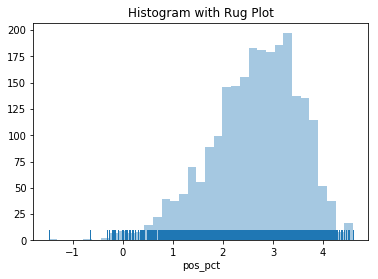

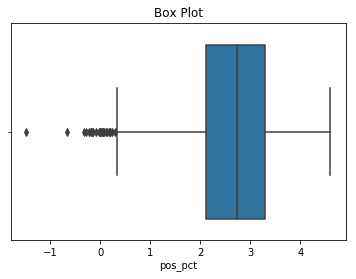

---------------------------
Data for duration : 

count    2381.000000
mean      821.763125
std       327.161291
min       135.000000
25%       587.000000
50%       850.000000
75%      1044.000000
max      3608.000000
Name: duration, dtype: float64


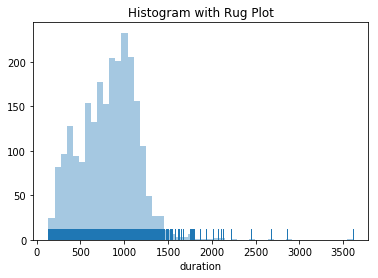

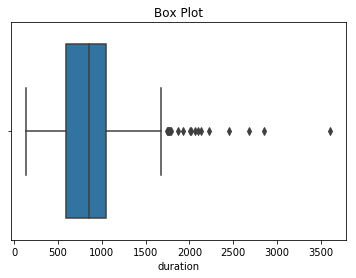

---------------------------
Data for num_speaker : 

count    2381.000000
mean        1.024780
std         0.198247
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: num_speaker, dtype: float64


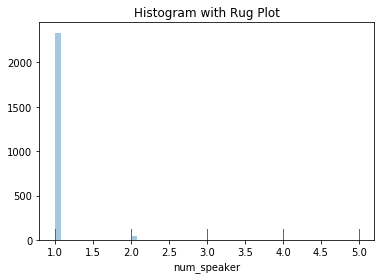

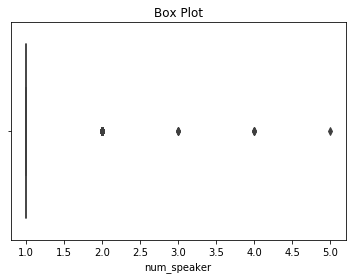

---------------------------
Data for laughter : 

count    2381.000000
mean        4.203276
std         6.160924
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        74.000000
Name: laughter, dtype: float64


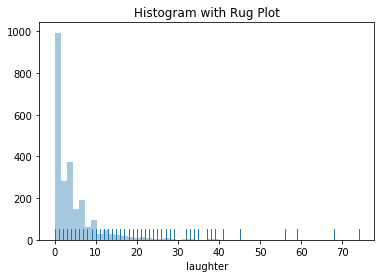

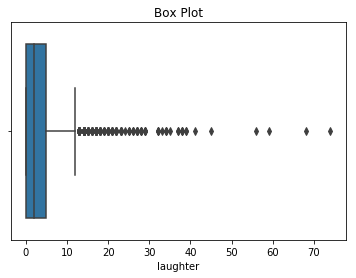

---------------------------
Data for applause : 

count    2381.000000
mean        2.255775
std         2.091925
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        18.000000
Name: applause, dtype: float64


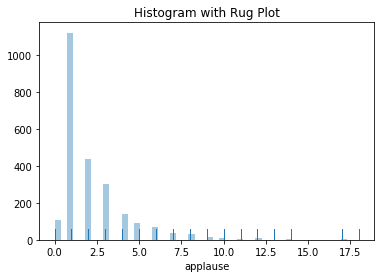

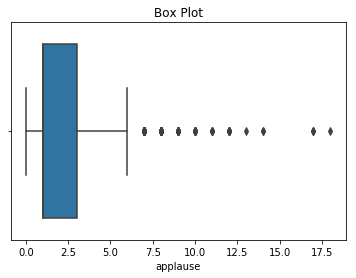

---------------------------


In [30]:
# EDA: Continuous Data, one-by-one
for i in ['pos_pct', 'duration', 'num_speaker', 'laughter', 'applause']:
    desc_hist_box(i, df_ted)
    print('---------------------------')

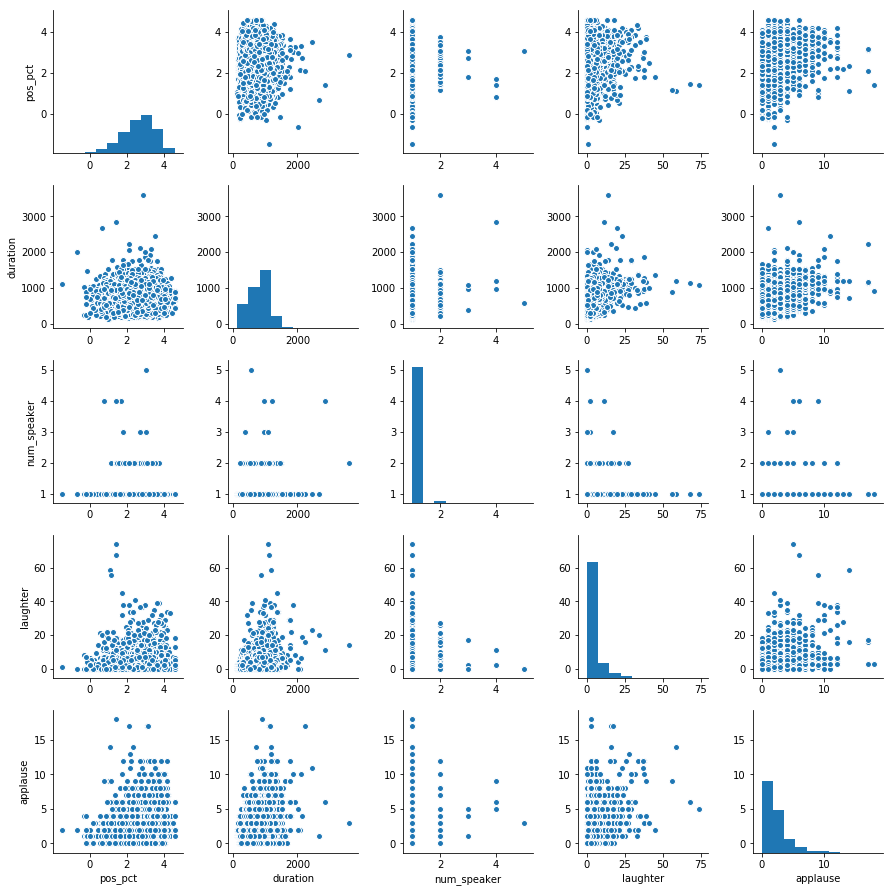

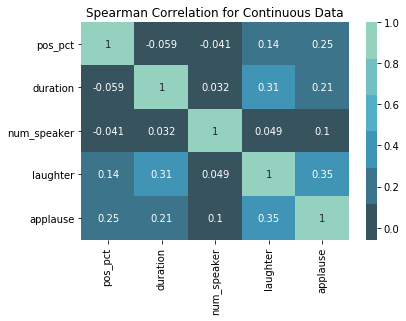

In [31]:
# EDA: Continuous Comparison

# pairplot
_ = sns.pairplot(data=df_ted, vars=['pos_pct', 'duration', 'num_speaker', 'laughter', 'applause'])
_ = plt.show()

# correlation heatmap
df_corr = df_ted.loc[:, ['pos_pct', 'duration', 'num_speaker', 'laughter', 'applause']].corr(method='spearman')
heat = sns.heatmap(df_corr, annot=True, cmap=sns.color_palette("GnBu_d"))
heat = plt.title("Spearman Correlation for Continuous Data")
heat = plt.show()

The results above show a few important issues:
1. There are significant outliers in __duration__.  TED talks are supposed to last no more than 18 minutes, according to official submission guidelines, but some go to 30 minutes or over an hour.
2. Most talks were given by one person and the data is sparse otherwise. Changing __num_speaker__ to a binary variable for "has more than one speaker" could be more useful. 
3. The distributions for __laughter__ and __applause__ have mostly 0's and 1's. This indicates that transcribers were likely not consistent in their in-/exclusion of audience reactions and their use for prediction may be inconsistent.

In [32]:
# EDA: Address continuous issues
#1. Significant outliers in duration
df_ted.loc[df_ted['duration'] > 25*60, ['name', 'duration', 'event_type']]

,name,duration,event_type
11,Jehane Noujaim: My wish: A global day of film,1538,TED Yearly
12,Larry Brilliant: My wish: Help me stop pandemics,1550,TED Yearly
39,Bono: My wish: Three actions for Africa,1672,TED Yearly
40,Edward Burtynsky: My wish: Manufactured landsc...,2065,TED Yearly
41,Robert Fischell: My wish: Three unusual medica...,1609,TED Yearly
66,Jane Goodall: What separates us from chimpanzees?,1645,TED Yearly
89,Evelyn Glennie: How to truly listen,1929,TED Yearly
96,Richard Dawkins: Militant atheism,1750,TED Yearly
146,Stephen Petranek: 10 ways the world could end,1782,TED Yearly
150,"Richard Branson: Life at 30,000 feet",1791,TED Yearly


Most talks over 25 minutes look to be from _TED Yearly_ or _TED Global_ talks and from well-known individuals, sometimes in controversial topics. This indicates they are something different from the normal TED talk and should be excluded as outliers.

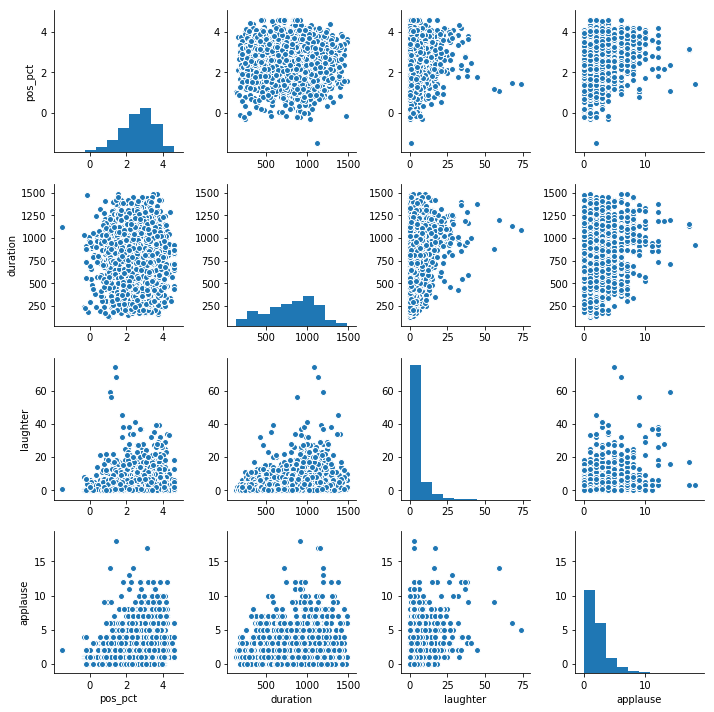

In [33]:
#EDA: Address continuous issues

#1. drop duration greater than 25 minutes
df_ted = df_ted.loc[df_ted['duration'] < 25*60, :].copy()

#2. Change num_speaker to binary for 1 speaker == False, >1 speaker == True
df_ted['speakers'] = df_ted.loc[:, 'num_speaker'].apply(lambda x: x>1)

# show pairplot
_ = sns.pairplot(data=df_ted, vars=['pos_pct', 'duration', 'laughter', 'applause'])
_ = plt.show()

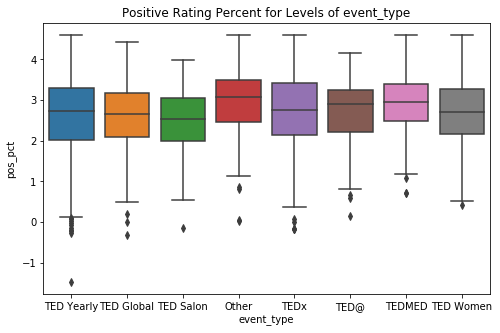

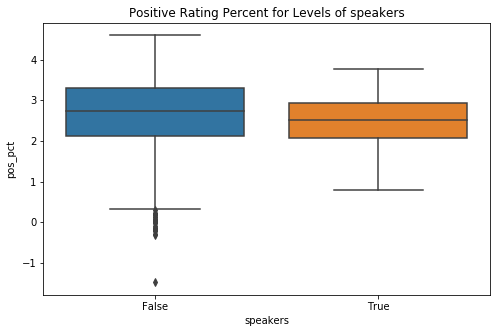

In [34]:
# EDA: Categorical Boxplots
for i in ['event_type', 'speakers']:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    sns.boxplot(y='pos_pct', x=i, data=df_ted, orient='v')
    plt.title("Positive Rating Percent for Levels of {0}".format(i))
    plt.show()

The charts above show that the positive rating percent has a similar distribution for different levels of categorical data, but some categories have more low-rated talks than others.

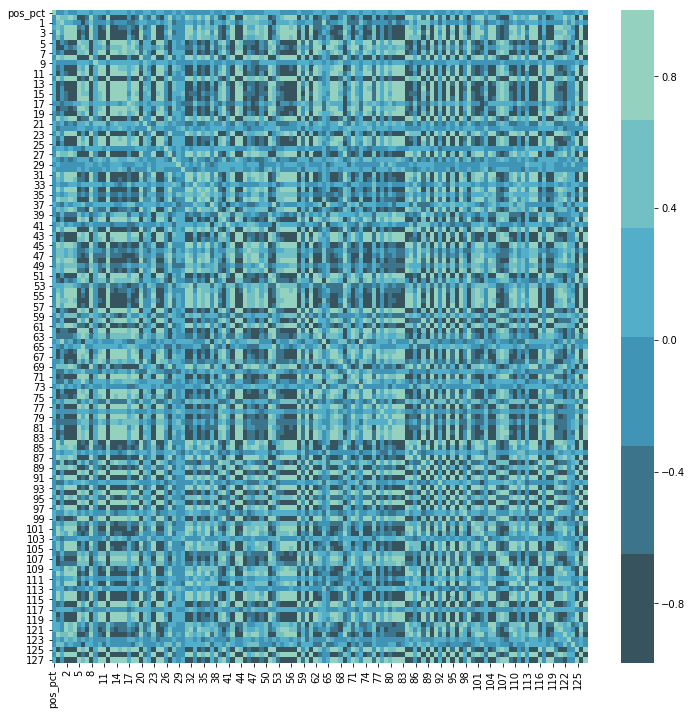

In [35]:
# EDA: 128 GloVe Columns
fig, ax = plt.subplots()
fig.set_size_inches((12,12))
df_corr = df_ted.loc[:, ['pos_pct'] + [str(i) for i in range(128)]].corr()
heat = sns.heatmap(df_corr, annot=False, cmap=sns.color_palette("GnBu_d"))
heat = plt.show()

This heatmap indicates there is some correlation between GloVe columns, but very little correltation between these columns and our outcome variable, __pos_pct__. Multicollinearity should not be an issue because the data will be normalized during fitting.

---

## <a class='anchor' id='4 Modeling'>4. Modeling</a>

Now that the data has been cleaned and investigated, we can finally create a regression model for it. The goal is to find a formula that can be used to accurately predict the positive rating percent of a talk, given its predictor variables. That is, given the __duration__ and kind of __event__, perhaps a reasonable __positive rating percent__ score can be estimated. Because the dataset contains over 100 variables, training models for every combination of variables could be too time-intensive. Instead, we can use the LASSO method to select the best model. LASSO regression penalizes predictor variables that have little predictive value and forces their coefficients to 0, which leaves them out of the model altogether. 

To assess the model, we will randomly split the data into a training group (70%) and a testing group (30%). In order to avoid overfitting, we will use 10-fold cross-validation using root mean squared error (RMSE) as the measure of fit. 10-fold cross-validation splits the test data into 10 equal, randomly-assigned groups. It fits a model using 9 of these groups and then tests it on the remaining one, then repeats until all groups have been tested against. The results are then averaged, giving a model and RMSE that are more generalizable. This final model is then tested against the 30% test group and given an RMSE against this new data.

In order to give some context to the RMSE, we will create four models. The baseline will be an __intercept-only model__, meaning there are no predictors. The RMSE is then just a measure of how "good" a model is if the predicted value is just the average of the test data set's mean score. The second will be a __metadata-only model__, which will exclude all of the GloVe vectors from consideration. The third will be a __word-only model__, which will consider _only_ the GloVe vectors in the model. The fourth will be an __overall model__ that will use both metadata and GloVe vectors to predict the positive rating percent. 

In [36]:
import itertools
import numpy as np
import warnings
from operator import itemgetter
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


# Separate data
predictors = ['duration', 'laughter', 'applause', 'event_type', 'speakers']
predictors += [str(i) for i in list(range(128))]
cats = ['speakers', 'event_type']
df_cat = pd.get_dummies(df_ted.loc[:, predictors + ['pos_pct']], columns=cats, drop_first=True)
X = df_cat.copy()
X = X.drop('pos_pct', axis=1)
y = df_cat.loc[:, 'pos_pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [101]:
def plot_results(train, test):
    
    a = pd.DataFrame(y_test)
    a['pred'] = test
    a['test'] = True
    
    b = pd.DataFrame(y_train)
    b['pred'] = train
    b['test'] = False
    
    c = pd.concat([a, b])
    d = c.copy()
    d['pred'] = d['pred'].apply(lambda x: np.exp(x)/(1+np.exp(x))+.01)
    d['pos_pct'] = d['pos_pct'].apply(lambda x: np.exp(x)/(1+np.exp(x))+.01)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_size_inches((10, 4))
    sns.regplot('pos_pct', 'pred', data=c.loc[c['test'] == False, :], fit_reg=False, ax=ax1, color='b')
    sns.regplot('pos_pct', 'pred', data=c.loc[c['test'] == True, :], fit_reg=False, ax=ax1, color='r')
    ax1.set_title('Predicted vs True Values for Transformed Data Format')
    ax1.set_ylabel('Predicted Values')
    ax1.set_xlabel('True Values')
    ax1.set_ylim((-2, 5))
    ax1.set_xlim((-2, 5))
    plt.legend(['Train Data', 'Test Data'])
        
    sns.regplot('pos_pct', 'pred', data=d.loc[d['test'] == False, :], fit_reg=False, ax=ax2, color='b')
    sns.regplot('pos_pct', 'pred', data=d.loc[d['test'] == True, :], fit_reg=False, ax=ax2, color='r')
    ax2.set_title('Predicted vs True Values for Original Data Format')
    ax2.set_ylabel('Predicted Values')
    ax2.set_xlabel('True Values')
    ax2.set_ylim((0, 1))
    ax2.set_xlim((0, 1))
    plt.legend(['Train Data', 'Test Data'])
    plt.tight_layout()
    plt.show()
    

Intercept Training RMSE: 0.894317
Intercept Testing RMSE: 0.874362


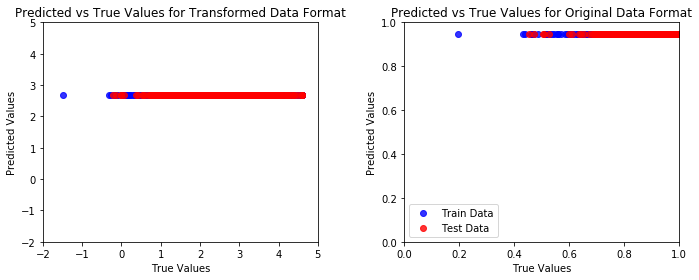

Training RMSE for no word vector model: 0.864791
Testing RMSE for no word vector model: 0.843168


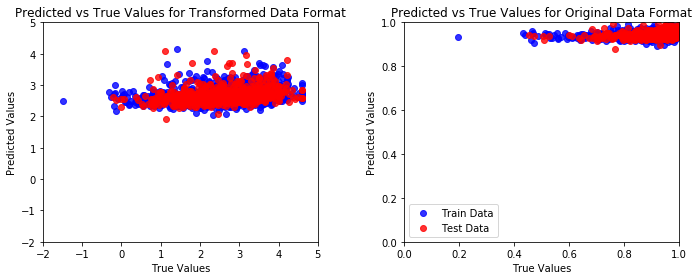

Training RMSE for word vector only model: 0.834978
Testing RMSE for word vector only model: 0.789398


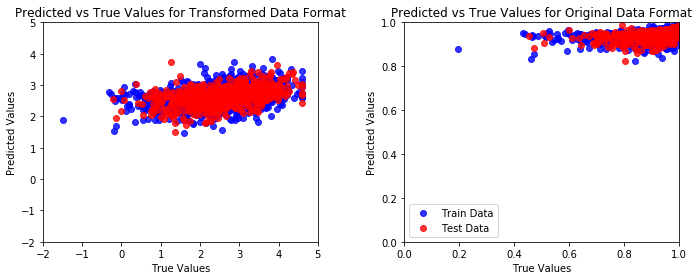

Training RMSE for overall model: 0.809745
Testing RMSE for overall model: 0.767749


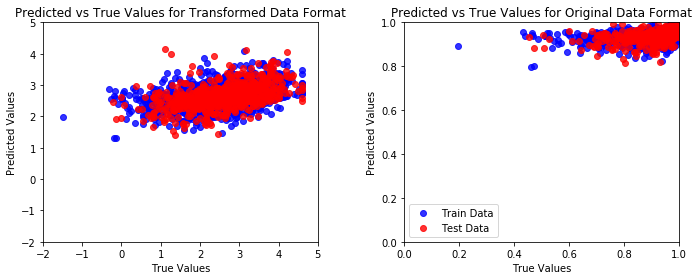

In [103]:
# Models

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
        # there are some convergence warnings in some Lasso fitting that we don't need to see here
    
    # Fit intercept model
    int_array_train = np.array([1]*1640).reshape(-1, 1)
    intercept = LinearRegression().fit(int_array_train, y_train)
    int_train_predict = intercept.predict(int_array_train)
    int_array_test = np.array([1]*703).reshape(-1, 1)
    int_test_predict = intercept.predict(int_array_test)
    print("Intercept Training RMSE:", round(np.sqrt(metrics.mean_squared_error(y_train, int_train_predict)), 6))
    print("Intercept Testing RMSE:", round(np.sqrt(metrics.mean_squared_error(y_test, int_test_predict)), 6))
    plot_results(int_train_predict, int_test_predict)
    
    
    # Find best model excluding word vectors
    lasso = LassoCV(normalize=True, cv=10, random_state=1)
    no_words = [i for i in X_train.columns if i not in [str(j) for j in range(128)]]
    lasso.fit(X_train.loc[:, no_words], y_train)
    no_word_y_train_pred = lasso.predict(X_train.loc[:, no_words])
    no_word_y_pred = lasso.predict(X_test.loc[:, no_words])
    print("Training RMSE for no word vector model:", round(np.sqrt(mean_squared_error(y_train, no_word_y_train_pred)), 6))
    print("Testing RMSE for no word vector model:", round(np.sqrt(mean_squared_error(y_test, no_word_y_pred)), 6))
    plot_results(no_word_y_train_pred, no_word_y_pred)
            
    # Find best model using only word vectors
    lasso = LassoCV(normalize=True, cv=10, random_state=1)
    only_words = [str(j) for j in range(128)]
    lasso.fit(X_train.loc[:, only_words], y_train)
    only_word_y_train_pred = lasso.predict(X_train.loc[:, only_words])
    only_word_y_pred = lasso.predict(X_test.loc[:, only_words])
    print("Training RMSE for word vector only model:", round(np.sqrt(mean_squared_error(y_train, only_word_y_train_pred)), 6))    
    print("Testing RMSE for word vector only model:", round(np.sqrt(mean_squared_error(y_test, only_word_y_pred)), 6))
    plot_results(only_word_y_train_pred, only_word_y_pred)
            
    # Find best overall model
    lasso = LassoCV(normalize=True, cv=10, random_state=1)
    lasso.fit(X_train, y_train)
    all_y_train_pred = lasso.predict(X_train)
    all_y_pred = lasso.predict(X_test)
    print("Training RMSE for overall model:", round(np.sqrt(mean_squared_error(y_train, all_y_train_pred)), 6))
    print("Testing RMSE for overall model:", round(np.sqrt(mean_squared_error(y_test, all_y_pred)), 6))
    plot_results(all_y_train_pred, all_y_pred)    

## <a class='anchor' id='5 Results'>5. Results</a>

The results may not be self-explanatory. Let's take a look at each piece in turn.

First, the RMSE for each model, train and test data compared (lower RMSE is better):  
__intercept__: 0.8943 vs 0.8744 (2.3% better)  
__no words__: 0.8648 vs 0.8432 (2.6% better)  
__only words__: 0.8350 vs 0.7894 (5.8% better)  
__overall__: 0.8098 vs 0.7678 (5.5% better)  

Now, the RMSE for each model's test data compared with the __intercept__ model's test data:  
__no words__: 3.7% better  
__only words__: 10.8% better  
__overall__: 13.9% better  

We can see that in every case, the models performed better on the test data than on the training data, which indicates there were some less extreme values in the test data than in the training data (this is reflected in the scatterplots). The RMSEs comparing each model to the __intercept__ model indicate that even on new data, models including the word vectors increase prediction accuracy by at least 10% and at best, about 14%.

The scatter plots for each model show two versions of the same data. The left plot is the transformed data $log(\frac{p}{1-p})$ for each positive rating percent $p$. The red dots are the test data and the blue dots are the training data. The plot axes represent the predicted (y-axis) versus the actual (x-axis) values for the data. The right plot is the original data, with predicted values transformed back into their original values, using the function $\frac{\mathrm{e}^{y}}{1+\mathrm{e}^{y}} = p$ where $y$ is the transformed data.

These plots show very clearly that although fitting to the word vector models improves the RMSE by at least 10%, even the best model fails to predict under-performance. In fact, even in the training data, the talk with just 20% positive ratings was predicted to receive 90%. __That is, while even a 14% improvement in prediction seems to indicate success, a model that cannot correctly identify even one under-performing TED Talk is wholly useless.__ 

The plots indicate why this may be: there are very few talks with less than 60% ratings. Even talks with less than 70% are underrepresented in the data. Because of this, the way forward is not throwing more model approaches at the data and hoping for success. Instead, the cultivation of more data (perhaps with different success metrics) or different input data could make this project successful.

The cultivation of more data could come from YouTube, where many more TED Talks are posted. Instead of comparing positive and negative user ratings, thumbs-up and thumbs-down votes could be used. Instead of TED transcripts, a copy of the closed captioning transcripts could be retreived through YouTube's API. In addition to this secondary/replacement data source, a different word representation model could be used as input. Something like Doc2Vec or tf-idf could perhaps contain an underlying structure that could better predict video success.